<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torch-geometric networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00


In [ ]:
# System & Utility Imports
import os
import pickle
import json
import numpy
# Math and Data Handling
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Machine Learning & Data Processing
from sklearn.model_selection import KFold, train_test_split
import shap
# PyTorch and PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
# NetworkX for Graph Handling
import networkx as nx
# Google Colab Specific Imports
from google.colab import drive


In [ ]:
# Get access to the dataset and load it up
drive.mount('/content/drive')
graphs_K = '/content/drive/My Drive/Disorder/Input_data/graphs_Kaia.pkl' # includes mostly repressors
graphs_S = '/content/drive/My Drive/Disorder/Input_data/graphs_STARK.pkl'
graphs_B = '/content/drive/My Drive/Disorder/Input_data/graphs_BINTU.pkl'

with open(graphs_K, 'rb') as f:
    graphs_K = pickle.load(f)
print(f"The total amount of graphs: {len(graphs_K)}")

with open(graphs_S, 'rb') as f:
    graphs_S = pickle.load(f)
print(f"The total amount of graphs: {len(graphs_S)}")

with open(graphs_B, 'rb') as f:
    graphs_B = pickle.load(f)
print(f"The total amount of graphs: {len(graphs_B)}")

Mounted at /content/drive
The total amount of graphs: 332
The total amount of graphs: 179
The total amount of graphs: 2425


# Define Model Parameters

In [ ]:
# Define model parameters
num_features = graphs_K[0].num_node_features # features should be consistent across all graphs
hidden_dim = 32    # You can adjust this
out_dim = 16       # You can adjust this
num_classes = len(set([graph.y.item() for graph in graphs_K]))  # Assuming y is a single value
class_names = [f'Class {i}' for i in range(num_classes)]  # Adjust based on your classes

# For M1H
for graph in graphs_K:
    if graph.y.item() == -1:
        graph.y = torch.tensor([0])
    elif graph.y.item() == 1:
        graph.y = torch.tensor([1])

# For M1H
for graph in graphs_S:
    if graph.y.item() == -1:
        graph.y = torch.tensor([0])
    elif graph.y.item() == 1:
        graph.y = torch.tensor([1])

# For M1H
for graph in graphs_B:
    if graph.y.item() == -1:
        graph.y = torch.tensor([0])
    elif graph.y.item() == 1:
        graph.y = torch.tensor([1])

Graph Attention network

In [ ]:
class GATWithMasking(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim, num_classes, num_heads=4):
        super(GATWithMasking, self).__init__()

        # GATConv layers
        self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Output one attention head for the final layer

        # BatchNorm and Dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm

        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)  # Add Dropout

        # Fully connected layer for classification output
        self.fc = nn.Linear(out_dim, num_classes)  # Output logits for num_classes

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GATConv layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.bn2(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling over the nodes in the same graph
        x = self.dropout(x)

        # Pass through final fully connected layer to output logits for each class
        x = self.fc(x)
        return x  # Logits for each class

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GAT_BINTU(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim, num_classes, num_heads=4):
        super(GAT_BINTU, self).__init__()

        # GATConv layers
        self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, concat=True)  # Additional GAT layer
        self.conv3 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Final GAT layer with 1 head

        # BatchNorm and Dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer for classification output
        self.fc = nn.Linear(out_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GATConv layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))  # New GAT layer
        x = self.bn3(self.conv3(x, edge_index))

        # Pooling over the nodes in the same graph
        x = global_mean_pool(x, batch)
        x = self.dropout(x)

        # Pass through final fully connected layer to output logits for each class
        x = self.fc(x)
        return x  # Logits for each class


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weight = weight
        self.loss_fn = nn.CrossEntropyLoss(weight=weight)

    def forward(self, outputs, labels):
        return self.loss_fn(outputs, labels)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()



def plot_confusion_matrix(true_labels, predicted_labels, class_names, save_path=None):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
        print(f'Saved confusion matrix plot to {save_path}')

    plt.close()

import os
import torch
import json
import numpy as np

def cross_validate(
    graphs, labels, num_features, hidden_dim, out_dim, num_classes, class_names,
    k_folds=5, num_epochs=100, save_path='/content/drive/My Drive/Disorder/Models/model_test'
):
    # Create the save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    #class_weights = torch.tensor([2.0, 1.0], dtype=torch.float32).to(device) # used for M1H data
    class_weights = torch.tensor([1.0, 20], dtype=torch.float32).to(device) # used for Bintu Lab
    fold_accuracies = []
    best_model = None
    best_accuracy = 0.0
    best_true_labels = []
    best_predicted_labels = []

    for fold, (train_idx, test_idx) in enumerate(stratified_kfold.split(graphs, labels)):
        print(f'\nFold {fold + 1}/{k_folds}')

        # Prepare training and test datasets
        train_dataset = [graphs[i] for i in train_idx]
        test_dataset = [graphs[i] for i in test_idx]

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        # Initialize the model
        model = GATWithMasking(num_features, hidden_dim, out_dim, num_classes).to(device)
        #model = GAT_BINTU(num_features, hidden_dim, out_dim, num_classes).to(device)

        # Define optimizer and loss function
        #optimizer = optim.Adam(model.parameters(), lr=0.01) # used for M1H data
        optimizer = optim.Adam(model.parameters(), lr=0.01) # used for Bintu
        criterion = nn.CrossEntropyLoss(weight=class_weights) # used for M1H data
        # Use FocalLoss instead of CrossEntropyLoss
        #criterion = FocalLoss(gamma=2.0, weight=class_weights) # for BINTU

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for data in train_loader:
                data = data.to(device)
                data.y = data.y.long()
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

        # Evaluation
        model.eval()
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                data.y = data.y.long()
                out = model(data)
                preds = out.argmax(dim=1)
                true_labels.extend(data.y.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

        # Calculate accuracy for the current fold
        accuracy = accuracy_score(true_labels, predicted_labels)
        fold_accuracies.append(accuracy)
        print(f'Fold {fold + 1} Accuracy: {accuracy:.4f}')

        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model.state_dict()
            best_true_labels = true_labels
            best_predicted_labels = predicted_labels

    avg_accuracy = sum(fold_accuracies) / k_folds
    print(f'\nAverage Accuracy across all folds: {avg_accuracy:.4f}')

    # Save the best model weights
    model_save_path = os.path.join(save_path, 'best_gat_model.pth')
    torch.save(best_model, model_save_path)
    print(f'Saved best model weights to {model_save_path}')

    # Save the true, predicted labels for the best model, save
    true_labels_path = os.path.join(save_path, 'best_true_labels.npy')
    predicted_labels_path = os.path.join(save_path, 'best_predicted_labels.npy')
    confusion_path = os.path.join(save_path, 'confusion.png')


    np.save(true_labels_path, best_true_labels)
    np.save(predicted_labels_path, best_predicted_labels)

    print(f'Saved true labels to {true_labels_path}')
    print(f'Saved predicted labels to {predicted_labels_path}')

    # Plot confusion matrix for the best model
    #plot_confusion_matrix(best_true_labels, best_predicted_labels, class_names)
    plot_confusion_matrix(best_true_labels, best_predicted_labels, class_names, save_path=confusion_path)


    return fold_accuracies, best_accuracy


In [ ]:
# from torch_geometric.loader import DataLoader
# from torch.utils.data import WeightedRandomSampler

# def cross_validate_sampled(
#     graphs, labels, num_features, hidden_dim, out_dim, num_classes, class_names,
#     k_folds=5, num_epochs=100, save_path='/content/drive/My Drive/Disorder/Models/model_test'
# ):
#     # Create the save directory if it doesn't exist
#     os.makedirs(save_path, exist_ok=True)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f'Using device: {device}')

#     stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

#     class_weights = torch.tensor([1.0, 5], dtype=torch.float32).to(device)
#     fold_accuracies = []
#     best_model = None
#     best_accuracy = 0.0
#     best_true_labels = []
#     best_predicted_labels = []

#     for fold, (train_idx, test_idx) in enumerate(stratified_kfold.split(graphs, labels)):
#         print(f'\nFold {fold + 1}/{k_folds}')

#         # Prepare training and test datasets
#         train_dataset = [graphs[i] for i in train_idx]
#         train_labels = [labels[i] for i in train_idx]
#         test_dataset = [graphs[i] for i in test_idx]

#         # Calculate class weights for oversampling
#         class_counts = np.bincount(train_labels)
#         sample_weights = [1.0 / class_counts[label] for label in train_labels]

#         # Create a WeightedRandomSampler for oversampling Class 1
#         sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#         # Use PyTorch Geometric DataLoader with the sampler
#         train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
#         test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#         # Initialize the model
#         #model = GATWithMasking(num_features, hidden_dim, out_dim, num_classes).to(device)

#         # Define optimizer and loss function
#         optimizer = optim.Adam(model.parameters(), lr=0.01)
#         #criterion = FocalLoss(gamma=2.0, weight=class_weights)
#         criterion = nn.CrossEntropyLoss(weight=class_weights) # used for M1H data

#         # Training loop
#         for epoch in range(num_epochs):
#             model.train()
#             total_loss = 0

#             for data in train_loader:
#                 data = data.to(device)
#                 data.y = data.y.long()
#                 optimizer.zero_grad()
#                 out = model(data)
#                 loss = criterion(out, data.y)
#                 loss.backward()
#                 optimizer.step()
#                 total_loss += loss.item()

#             avg_loss = total_loss / len(train_loader)
#             print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

#         # Evaluation
#         model.eval()
#         true_labels = []
#         predicted_labels = []

#         with torch.no_grad():
#             for data in test_loader:
#                 data = data.to(device)
#                 data.y = data.y.long()
#                 out = model(data)
#                 preds = out.argmax(dim=1)
#                 true_labels.extend(data.y.cpu().numpy())
#                 predicted_labels.extend(preds.cpu().numpy())

#         # Calculate accuracy for the current fold
#         accuracy = accuracy_score(true_labels, predicted_labels)
#         fold_accuracies.append(accuracy)
#         print(f'Fold {fold + 1} Accuracy: {accuracy:.4f}')

#         # Save the best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_model = model.state_dict()
#             best_true_labels = true_labels
#             best_predicted_labels = predicted_labels

#     avg_accuracy = sum(fold_accuracies) / k_folds
#     print(f'\nAverage Accuracy across all folds: {avg_accuracy:.4f}')

#     # Save the best model weights
#     model_save_path = os.path.join(save_path, 'best_gat_model.pth')
#     torch.save(best_model, model_save_path)
#     print(f'Saved best model weights to {model_save_path}')

#     # Save the true, predicted labels for the best model
#     true_labels_path = os.path.join(save_path, 'best_true_labels.npy')
#     predicted_labels_path = os.path.join(save_path, 'best_predicted_labels.npy')
#     confusion_path = os.path.join(save_path, 'confusion.png')

#     np.save(true_labels_path, best_true_labels)
#     np.save(predicted_labels_path, best_predicted_labels)

#     print(f'Saved true labels to {true_labels_path}')
#     print(f'Saved predicted labels to {predicted_labels_path}')

#     # Plot confusion matrix for the best model
#     plot_confusion_matrix(best_true_labels, best_predicted_labels, class_names, save_path=confusion_path)

#     return fold_accuracies, best_accuracy


In [ ]:
# Assuming labels are derived from the graphs
labels_K = [graph.y.item() for graph in graphs_K]
labels_S = [graph.y.item() for graph in graphs_S]
labels_B = [graph.y.item() for graph in graphs_B]
labels = [labels_K, labels_S, labels_B]
save_path_ISO = '/content/drive/My Drive/Disorder/Models/TF_Isoforms'
save_path_STARK = '/content/drive/My Drive/Disorder/Models/STARK'
save_path_BINTU = '/content/drive/My Drive/Disorder/Models/Bintu'

paths = [save_path_ISO, save_path_STARK, save_path_BINTU]
graphs = [graphs_K, graphs_S, graphs_B]
for i in range(2, 3):
# Cross-validation
  fold_accuracies, best_accuracy = cross_validate(
      graphs=graphs[i],
      labels=labels[i],
      num_features=num_features,
      hidden_dim=hidden_dim,
      out_dim=out_dim,
      num_classes=num_classes,
      class_names=class_names,
      k_folds=5,
      num_epochs=50,
      save_path = paths[i]
  )

  print(f"Cross-validation accuracies: {fold_accuracies}")
  print(f"Best accuracy: {best_accuracy}")


Using device: cpu

Fold 1/5
Epoch 1/50, Loss: 0.5171
Epoch 2/50, Loss: 0.4668
Epoch 3/50, Loss: 0.4175
Epoch 4/50, Loss: 0.3979
Epoch 5/50, Loss: 0.3646
Epoch 6/50, Loss: 0.3581
Epoch 7/50, Loss: 0.3553
Epoch 8/50, Loss: 0.3316
Epoch 9/50, Loss: 0.3329
Epoch 10/50, Loss: 0.3498
Epoch 11/50, Loss: 0.3412
Epoch 12/50, Loss: 0.3277
Epoch 13/50, Loss: 0.3001
Epoch 14/50, Loss: 0.3103
Epoch 15/50, Loss: 0.2854
Epoch 16/50, Loss: 0.3104
Epoch 17/50, Loss: 0.2902
Epoch 18/50, Loss: 0.2496
Epoch 19/50, Loss: 0.2867
Epoch 20/50, Loss: 0.2376
Epoch 21/50, Loss: 0.2442
Epoch 22/50, Loss: 0.2526
Epoch 23/50, Loss: 0.2603
Epoch 24/50, Loss: 0.2461
Epoch 25/50, Loss: 0.2605
Epoch 26/50, Loss: 0.2281
Epoch 27/50, Loss: 0.2306
Epoch 28/50, Loss: 0.2412
Epoch 29/50, Loss: 0.2376
Epoch 30/50, Loss: 0.2554
Epoch 31/50, Loss: 0.2319
Epoch 32/50, Loss: 0.2355
Epoch 33/50, Loss: 0.2616
Epoch 34/50, Loss: 0.2370
Epoch 35/50, Loss: 0.2364
Epoch 36/50, Loss: 0.2403
Epoch 37/50, Loss: 0.2284
Epoch 38/50, Loss: 

In [ ]:
fold_accuracies, best_accuracy = cross_validate(
    graphs=graphs_S,
    labels=labels,
    num_features=num_features,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    num_classes=num_classes,
    class_names=class_names,
    k_folds=5,
    num_epochs=100,
    save_path = save_path_STARK
)

Using device: cpu


ValueError: Found input variables with inconsistent numbers of samples: [179, 332]

In [ ]:
for i in range(1,2):
  print(i)

1


### Testing on a different dataset

In [ ]:
def load_best_model(num_features, hidden_dim, out_dim, num_classes, model_path):
    # Initialize the model architecture
    model = GATWithMasking(num_features, hidden_dim, out_dim, num_classes)

    # Load the best model's weights
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model
import torch
from torch_geometric.loader import DataLoader

from sklearn.metrics import accuracy_score

def predict(
    new_graphs, true_labels, num_features, hidden_dim, out_dim, num_classes, class_names, model_path, batch_size=16
):
    # Load the best model
    model = load_best_model(num_features, hidden_dim, out_dim, num_classes, model_path)
    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Create a DataLoader for the new dataset
    new_loader = DataLoader(new_graphs, batch_size=batch_size, shuffle=False)

    # Initialize lists to store predictions
    all_predictions = []

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for data in new_loader:
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

            # Run the model to get predictions
            out = model(data)
            preds = out.argmax(dim=1)  # Get the predicted class

            all_predictions.extend(preds.cpu().numpy())

    # Calculate accuracy on the new dataset
    accuracy = accuracy_score(true_labels, all_predictions)
    print(f"Accuracy on the new dataset: {accuracy:.4f}")

    # Plot the confusion matrix
    plot_confusion_matrix(true_labels, all_predictions, class_names)

    return all_predictions
def get_class_names_from_graphs(graphs):
    # Extract unique labels from the graphs
    unique_labels = sorted(set([int(graph.y.item()) for graph in graphs]))

    # Map each label to a class name (e.g., 0 -> 'Class 0', 1 -> 'Class 1')
    class_names = [f'Class {label}' for label in unique_labels]
    return class_names
def get_true_labels_from_graphs(graphs):
    # Extract the 'y' attribute from each graph in the list
    true_labels = [int(graph.y.item()) for graph in graphs]
    return true_labels
def get_class_names_from_graphs(graphs):
    # Extract unique labels from the graphs
    unique_labels = sorted(set([int(graph.y.item()) for graph in graphs]))

    # Map each label to a class name (e.g., 0 -> 'Class 0', 1 -> 'Class 1')
    class_names = [f'Class {label}' for label in unique_labels]
    return class_names

Test the model on the TF dataset

In [ ]:
graphs_kaia = '/content/drive/My Drive/Disorder/Input_data/graphs_full_BINTU_STARK_cut.pkl'
with open(graphs_kaia, 'rb') as f:
    graphs_kaia = pickle.load(f)
print(f"The total amount of graphs: {len(graphs_kaia)}")
for graph in graphs_kaia:
    if graph.y.item() == -1:
        graph.y = torch.tensor([0])
    elif graph.y.item() == 1:
        graph.y = torch.tensor([1])

The total amount of graphs: 504


<ipython-input-7-a8dce11eb43b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Accuracy on the new dataset: 0.6468


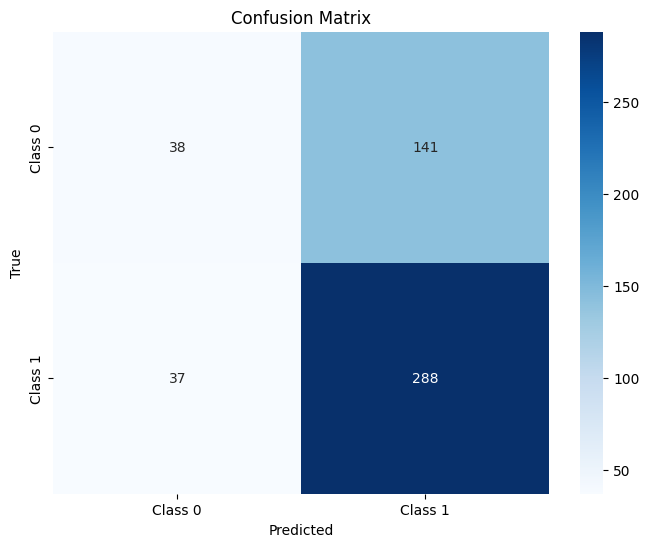

In [ ]:
true_labels = get_true_labels_from_graphs(graphs_kaia)
# Extract class names from the graphs_kaia dataset
class_names_kaia = get_class_names_from_graphs(graphs_kaia)
# Predict on the new dataset
model_path = '/content/drive/My Drive/Disorder/Models/model_test/best_gat_model.pth'
predictions = predict(
    new_graphs=graphs_kaia,
    true_labels=true_labels,
    num_features=graphs[0].num_node_features,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    num_classes=num_classes,
    class_names=class_names_kaia,
    model_path=model_path
)

In [ ]:
graphs[0].num_node_features

131